In [5]:
import awswrangler  as wr
import pandas as pd
import pymysql
import datetime
import requests


In [6]:
sql_query = '''
with ubl_raw as  (
--
select
  from_iso8601_timestamp(json_extract_scalar(user_properties, '$.first_at'))  + interval '9' hour AS first_at
, client_access_time as reg_ts
, cast( json_extract_scalar ( event_properties , '$.stay_time_seconds') as integer) as stay_time
, case
    when device like 'Web%' then case when device like '%Mobile%'  then 'mobile_web'
                                when device like '%Desktop%' then  'desktop'  end
    when device like 'App%' then 'App'

end as device_type
-- , row_number ( ) over ( partition by uuid order by client_access_time ) rn
, json_extract_scalar(user_properties, '$.exp_all_no_huddle_empty_absolute_control_group') global_control
, row_number() over (partition by uuid order by client_access_time  ) rn
, json_extract_scalar(user_properties, '$.initial_utm_medium') initial_utm_medium
, json_extract_scalar(user_properties, '$.initial_utm_source') initial_utm_source
, json_extract_scalar(user_properties, '$.initial_utm_campaign') initial_utm_campaign
, *
/*
 , json_extract_scalar(user_properties, '$.')
*/
from moyo_logs.user_behavior_logs
where 1=1
    and date_ymd>= '2023-05-06'  -- 5월 6일 - 5월 15일
    and date_ymd<= '2023-05-15'
    and from_iso8601_timestamp(json_extract_scalar(user_properties, '$.first_at'))  + interval '9' hour
        between  date('2023-05-06') and date('2023-05-14')

)
-- rn 3 -> cross join
, pv_rn as (
select
 row_number() over (partition by uuid order by client_access_time  ) pv_rn
, date_diff( 'hour', first_at, reg_ts) as diff_hour
  ,a.*
from ubl_raw a
where 1=1
    and  a.category = 'pageview' and a.navigation = 'plan_detail'
    )
, pv_rn_3 as ( -- uuis distinct
select *
from pv_rn
where 1=1
    and pv_rn = 3
)
, c_join1 as (
select
b.reg_ts as reg_ts_3
, a.*
from ubl_raw a
join pv_rn_3 b on a.uuid = b.uuid and a.reg_ts <= b.reg_ts -- pv
)
-- select *
-- from c_join1
-- limit 100 -- 3 pv  이내만 분석
--  ;

-- , filter_period as (
-- select
-- from ubl_raw a
-- where 1=1
--     and  a.rn <= 3 -- 3 pv  이내만 분석
--     )
, score as (
select
 cast ( case when category = 'impression' and object_type = 'review'
    then json_extract_scalar ( event_properties , '$.view_score')   end as double )  as review_sc
,cast ( case when category = 'impression' and object_type = 'review_header'
    then json_extract_scalar ( event_properties , '$.view_score') end as double  ) as review_header_sc
, case when category = 'apply' and object_type = 'plan'
    then 1 else 0 end as apply_cnt -- 1: apply, 0: not apply (view)
, case when   category = 'pageview' and navigation = 'plan_detail'
    then 1 else 0 end as pv_cnt
, *
from c_join1
)
, raw1 as (
select
uuid
, avg( review_sc) as review_sc_avg
, max( review_sc) as review_sc_max
, min( review_sc) as review_sc_min
, avg( review_header_sc) as review_header_sc_avg
, max( review_header_sc) as review_header_sc_max
, min( review_header_sc) as review_header_sc_min
, sum( apply_cnt) as apply_cnt
, sum (pv_cnt) as pv_cnt
, count ( review_sc) as review_cnt
from score
where 1=1
group by 1
)
select  *
from raw1

-- select
-- apply_cnt
-- , avg( review_sc_avg) as review_sc_avg
-- , avg( review_sc_max) as review_sc_max
-- , avg( review_sc_min) as review_sc_min
-- from raw1
-- group by 1
'''

In [7]:
df = wr.athena.read_sql_query(sql=sql_query, database="moyo_logs")
from datetime import datetime, timedelta
import pytz

In [11]:
# pair plot 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


/Users/ringokwon/anaconda3/lib/python3.10/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/Users/ringokwon/anaconda3/lib/python3.10/site-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
/Users/ringokwon/anaconda3/lib/python3.10/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/Users/ringokwon/anaconda3/lib/python3.10/site-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed objec

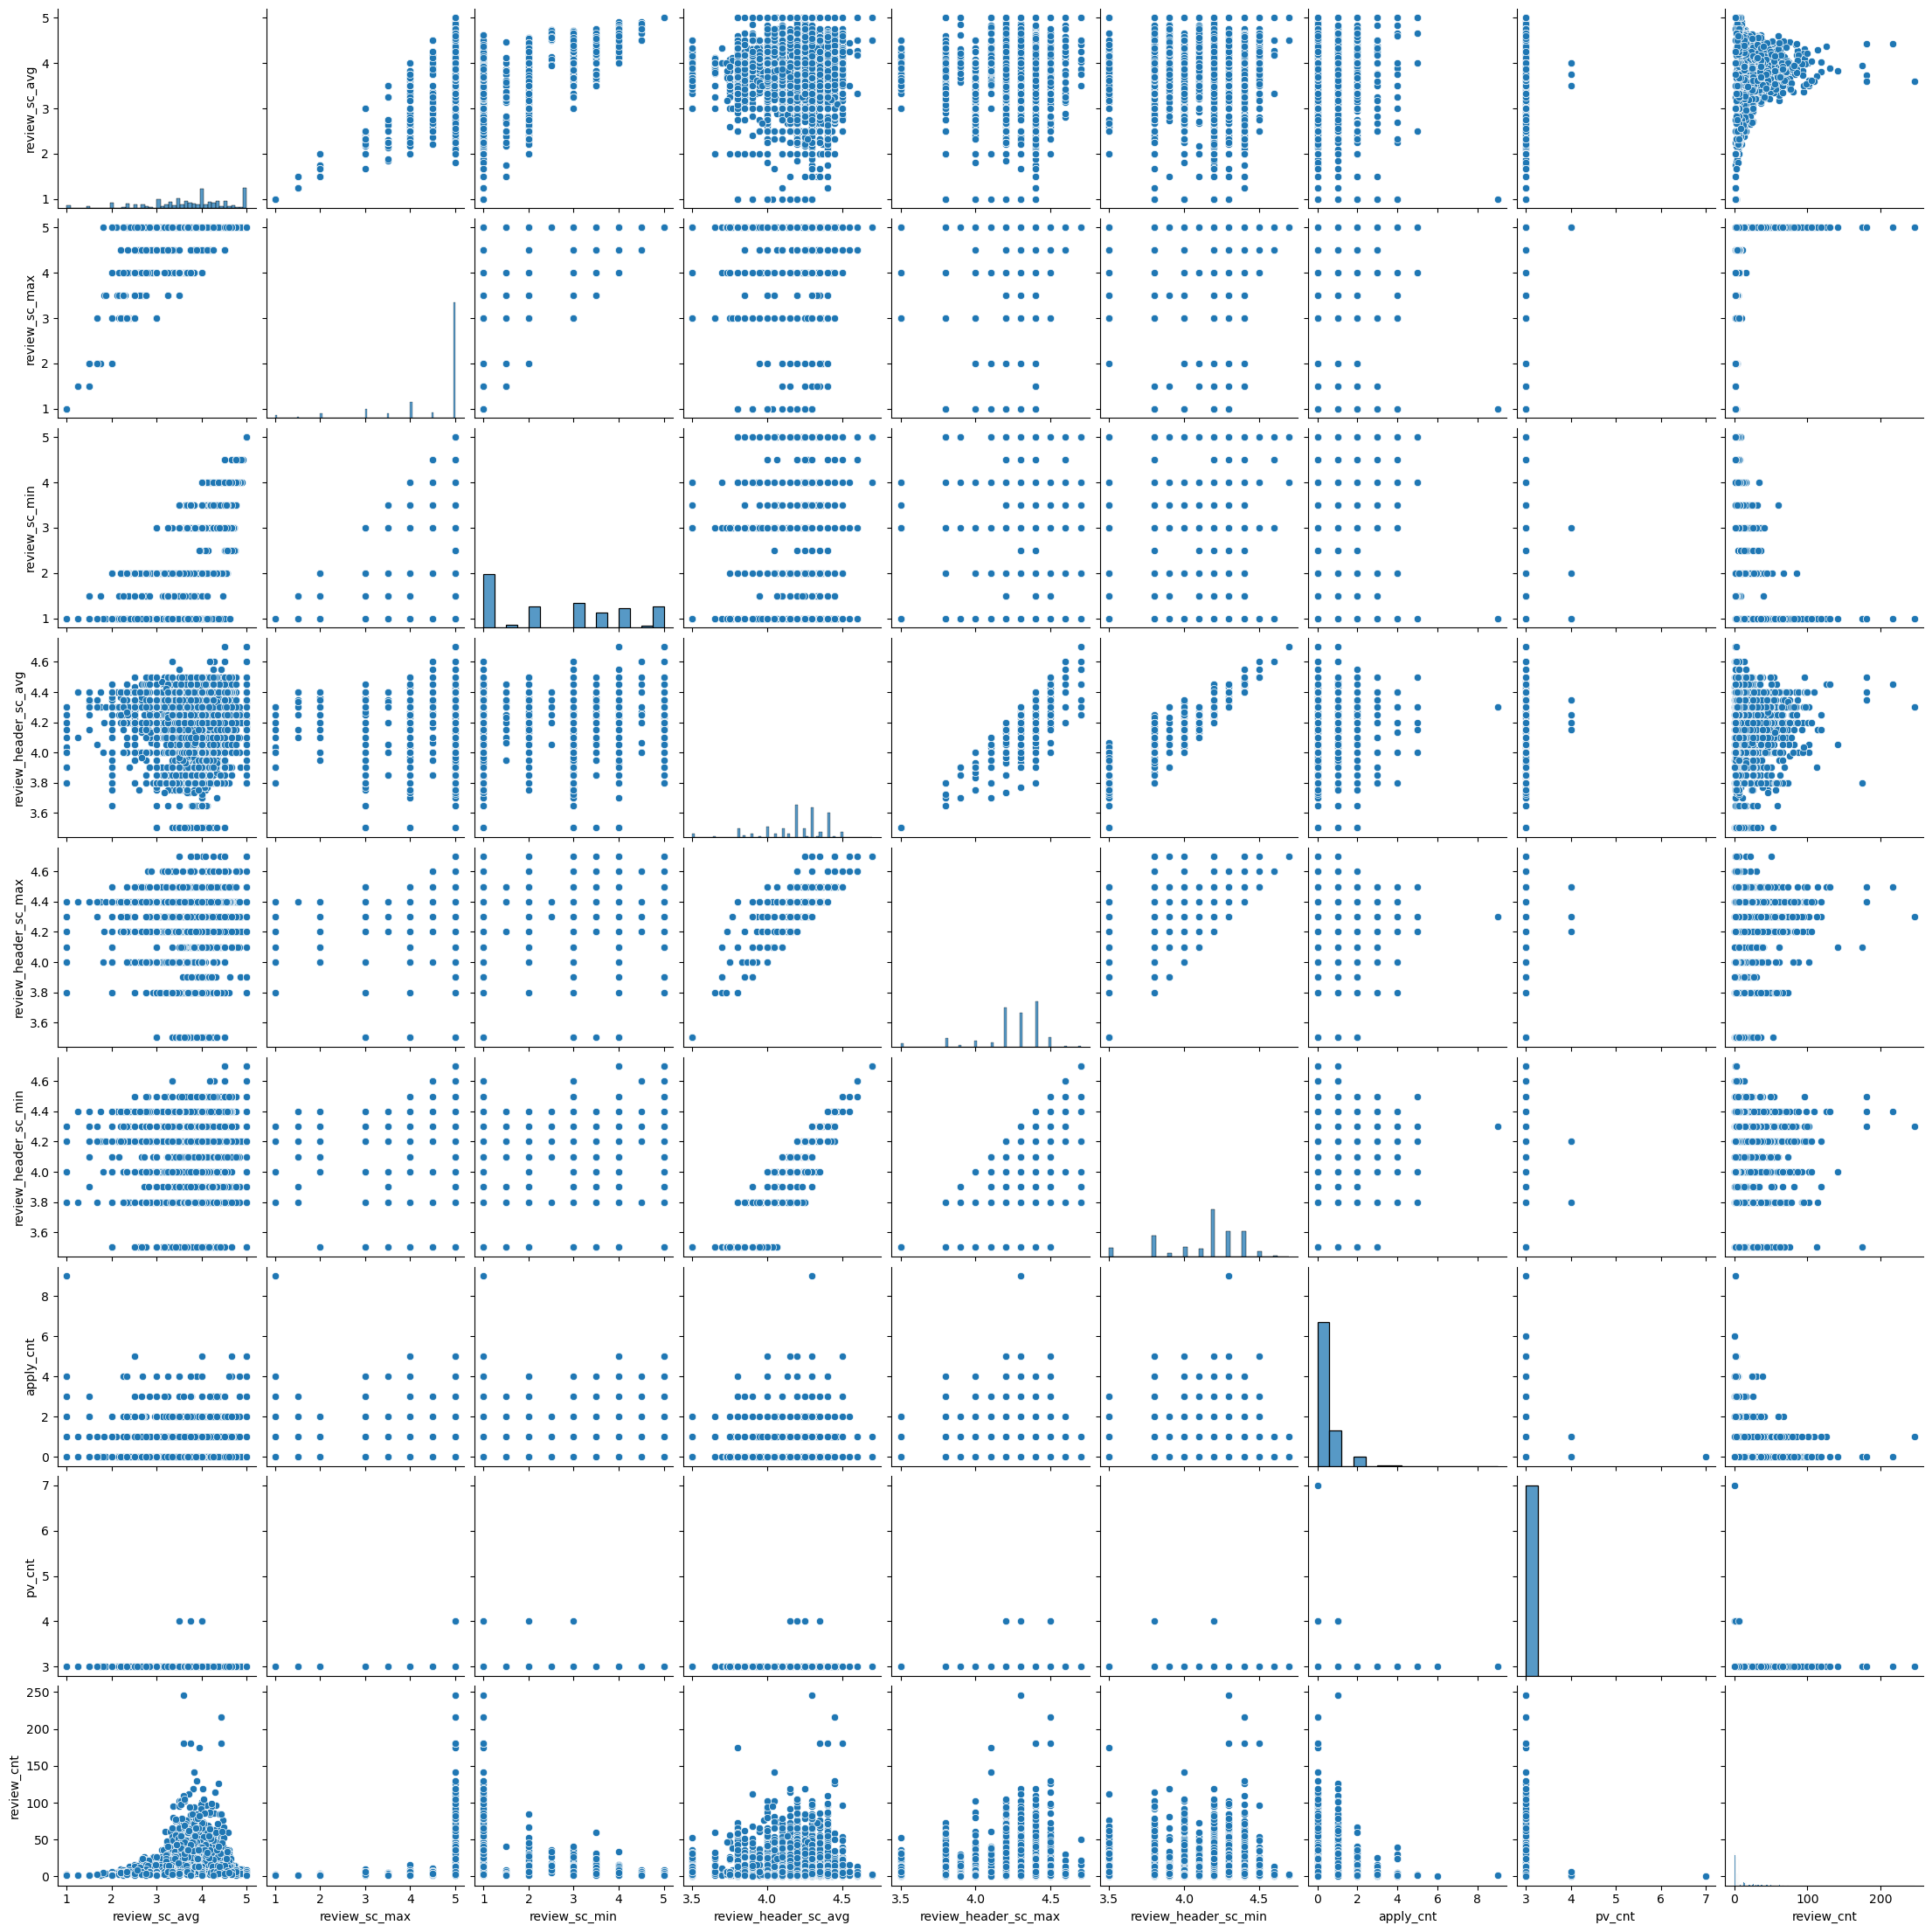

In [18]:
sns.pairplot(df)

In [10]:
!pip install seaborn


  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)


In [8]:
# correlation
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

corr = df.corr(method='pearson')

/var/folders/df/cs55_cks0_3_zx14p6v7h1_h0000gn/T/ipykernel_11781/2198949905.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr(method='pearson')


In [9]:
corr

,review_sc_avg,review_sc_max,review_sc_min,review_header_sc_avg,review_header_sc_max,review_header_sc_min,apply_cnt,pv_cnt,review_cnt
review_sc_avg,1.000000,0.700488,0.699886,-0.081832,-0.086919,-0.064009,0.045870,0.001412,0.034982
review_sc_max,0.700488,1.000000,0.114191,-0.095423,-0.017912,-0.142128,-0.008549,0.009087,0.219930
review_sc_min,0.699886,0.114191,1.000000,0.007292,-0.085959,0.081209,0.072416,-0.010981,-0.374180
review_header_sc_avg,-0.081832,-0.095423,0.007292,1.000000,0.885851,0.924797,-0.019742,0.003774,-0.030189
review_header_sc_max,-0.086919,-0.017912,-0.085959,0.885851,1.000000,0.645069,-0.065235,0.011435,0.040477
review_header_sc_min,-0.064009,-0.142128,0.081209,0.924797,0.645069,1.000000,0.020049,-0.003065,-0.082102
apply_cnt,0.045870,-0.008549,0.072416,-0.019742,-0.065235,0.020049,1.000000,0.002764,-0.057239
pv_cnt,0.001412,0.009087,-0.010981,0.003774,0.011435,-0.003065,0.002764,1.000000,-0.006283
review_cnt,0.034982,0.219930,-0.374180,-0.030189,0.040477,-0.082102,-0.057239,-0.006283,1.000000
